In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

### Data formats
"ratings.dat" file format - UserID::MovieID::Rating::Timestamp
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings


"movies.dat" format - MovieID::Title::Genres
- Genres are pipe-separated and are selected from the following genres: [Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]
- Titles are identical to titles provided by the IMDB (including
year of release)
- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist


"users.dat" file format - UserID::Gender::Age::Occupation::Zip-code
- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges: {1:  "Under 18", 18:  "18-24", 25:  "25-34", 35:  "35-44", 45:  "45-49", 50:  "50-55", 56:  "56+"}

- Occupation is chosen from the following choices: {0:  "other" or "not specified", 1:  "academic/educator", 2:  "artist", 3:  "clerical/admin", 4:  "college/grad student", 5:  "customer service", 6:  "doctor/health care", 7:  "executive/managerial", 8:  "farmer", 9:  "homemaker", 10:  "K-12 student", 11:  "lawyer", 12:  "programmer", 13:  "retired", 14:  "sales/marketing", 15:  "scientist", 16:  "self-employed", 17:  "technician/engineer", 18:  "tradesman/craftsman", 19:  "unemployed", 20:  "writer"}

In [3]:
ratings = pd.read_csv('./cleaned_datasets/ratings.dat', 
                 delimiter='::', 
                 encoding='latin1', 
                 engine = 'python', 
                 header = None,
                 names = ['user_id', 'movie_id', 'rating', 'timestamp']
)
movies = pd.read_csv('./cleaned_datasets/movies.dat', 
                 delimiter='::', 
                 encoding = 'latin1',
                 header = None,
                 engine = 'python',
                 names = ['movie_id', 'title', 'genres']
)
users = pd.read_csv('./cleaned_datasets/users.dat', 
                 delimiter='::', 
                 encoding='latin1', 
                 engine = 'python', 
                 header = None,
                 names = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
)

In [4]:
from datetime import datetime

# TODO: later change to hive.sql
ratings['timestamp'] = ratings['timestamp'].apply(lambda timestamp: datetime.fromtimestamp(timestamp))

ratings = ratings.sort_values(['rating', 'timestamp'], ascending = [False, False])
ratings.head()

,user_id,movie_id,rating,timestamp
825438,4958,1407,5,2003-02-28 09:47:23
984025,5948,1180,5,2003-02-28 05:11:19
984632,5950,3196,5,2003-02-27 09:54:22
984849,5950,111,5,2003-02-27 09:50:41
984825,5950,2329,5,2003-02-27 09:45:48


In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
# merge datasets
merged = pd.merge(ratings, users, how = 'inner', on = 'user_id')
merged = pd.merge(merged, movies, how = 'inner', on = 'movie_id')
merged.head()

ratings_cleaned = merged[['user_id', 'movie_id', 'rating']].sort_values(by=['user_id', 'movie_id', 'rating'])
print(ratings_cleaned.head())

print(f"Unique number of users in the dataset: {ratings_cleaned['user_id'].nunique()}")
print(f"Unique number of movies in the dataset: {ratings_cleaned['movie_id'].nunique()}")
    # why is number of movies smaller?? what happened?
    # are some movies not rated at all?

        user_id  movie_id  rating
171933        1         1       5
911414        1        48       5
21420         1       150       5
49104         1       260       4
34221         1       527       5
Unique number of users in the dataset: 6040
Unique number of movies in the dataset: 3706


#### Some movies in the movie dataset does not have any ratings.
These movies will not be used as input data.

In [8]:
# hence there are some movies missing in merged dataset
ratings[ratings['movie_id'] == 51]

,user_id,movie_id,rating,timestamp


In [9]:
missing_movies = movies[~movies['movie_id'].isin(ratings_cleaned['movie_id'].unique())]
missing_movies

,movie_id,title,genres
50,51,Guardian Angel (1994),Action|Drama|Thriller
107,109,Headless Body in Topless Bar (1995),Comedy
113,115,Happiness Is in the Field (1995),Comedy
141,143,Gospa (1995),Drama
281,284,New York Cop (1996),Action|Crime
...,...,...,...
3581,3650,Anguish (Angustia) (1986),Horror
3681,3750,Boricua's Bond (2000),Drama
3759,3829,Mad About Mambo (2000),Comedy|Romance
3786,3856,Autumn Heart (1999),Drama


### Train test split

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(ratings_cleaned, test_size=0.25, random_state=42)

print(f"Unique number of users in the dataset: {train['user_id'].nunique()}")
print(f"Unique number of movies in the dataset: {train['movie_id'].nunique()}")

train

Unique number of users in the dataset: 6040
Unique number of movies in the dataset: 3670


,user_id,movie_id,rating
681495,3704,3915,4
305697,1924,920,4
38263,4837,2791,4
654051,867,1921,5
61083,2631,1028,4
...,...,...,...
381337,1586,3507,5
927941,2129,2790,3
302949,854,1704,4
91883,4033,1199,5


# Item-based KNN collaborative filtering model 
- input user_id & desired number of similar users, and will recommend movies rated by similar users  

#### Why KNN?

1. Simplicity and Interpretability

2. Collaborative Filtering

KNN works well in collaborative filtering, a common approach in recommendation systems. This is where the algorithm recommends movies based on similarities between users (user-based collaborative filtering) or between movies (item-based collaborative filtering). For example, in item-based filtering, KNN recommends movies similar to the ones a user has liked in the past by comparing the movie’s features.

3. Good for Small to Medium Datasets

KNN performs relatively well on small to medium datasets without requiring extensive training. Since it operates by calculating distances between data points, it works best when the dataset isn’t too large or when computing power is sufficient. For larger datasets, optimizations or alternative models like matrix factorization or deep learning might be necessary.

4. Adaptability to Feature Similarity

KNN can be adapted to various similarity metrics, such as Euclidean distance, cosine similarity, or Pearson correlation, depending on how you define movie similarity. For instance, cosine similarity might work well when comparing users’ rating patterns or the attributes of movies.

5. Cold Start Problem

However, KNN is computationally expensive when dealing with very large datasets and may not capture complex relationships between movies or users as effectively as other models (e.g., matrix factorization or deep learning).

Surpise KNNBasic model documentation : https://surprise.readthedocs.io/en/stable/knn_inspired.html

> Similarity Measures

Cosine and Pearson similarity measures are commonly used in KNN-based collaborative filtering because they help quantify the degree of similarity between two vectors (users or items) based on their rating patterns. 


In [11]:
# Install necessary libraries
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy
import pandas as pd

In [43]:
df = ratings_cleaned[['user_id', 'movie_id', 'rating']]

# Define the reader object and load the data into Surprise's dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)

# Split the dataset into training and test sets
trainset, testset = train_test_split(data, test_size=0.01)

> Error metrics
- MSE evaluates how closely the predicted ratings match the true ratings
- MSE is the square root of MSE, which makes it more interpretable because it’s in the same units as the ratings 
- MAE measures the average magnitude of errors between predicted and true ratings, without considering the direction of the errors

<b> Similarity measures </b>

> Cosine Similarity

Cosine similarity measures the cosine of the angle between two non-zero vectors (such as user or item rating vectors) in an n-dimensional space

- Independent of Magnitude: 

        Cosine similarity focuses on the direction rather than the magnitude of the vectors. users may rate movies very differently in absolute terms, but if the pattern of their ratings (e.g., which movies they rate high or low) is similar, they will be considered similar.

- Good for Sparse Data: 

        Cosine similarity works well in cases where the user-item matrix is sparse (contains many missing values). Since it only looks at the ratings for items both users have rated, it ignores missing values.

- Captures Similar Preferences: 

        Cosine similarity captures how similarly users behave in terms of their preferences (even if their ratings scale is different), which is especially useful when recommending items based on similar preferences.

> Pearson Correlation

Pearson correlation measures the linear correlation between two variables. It evaluates how well the ratings of two users (or items) can be described as a linear relationship.

- Removes Rating Bias: 

        Pearson correlation centers the ratings by subtracting the user’s average rating. This is important because some users tend to give generally higher ratings than others. Pearson correlation can capture how users deviate from their own average behavior, allowing it to ignore differences in absolute rating levels.
- Captures Linear Relationships: 

        Pearson correlation is useful when you’re interested in linear relationships between users or items. For example, if two users consistently rate movies relative to their preferences (e.g., one user may rate 4, 5, 3, and another may rate 2, 3, 1), Pearson will capture that they have similar relative preferences.
- Normalizes Ratings: 

        Since it normalizes the ratings by subtracting the mean, Pearson correlation is effective when users have different rating scales. It focuses on the relative difference in ratings rather than absolute scores.


### Hyperparameter tuning

In [44]:
train_rmses, train_maes, test_rmses, test_maes = [], [], [], []
ks = list(range(35, 47, 1))

for k in ks:

    print("For k value : {} --> KNN item-based collaborative filtering model".format(k))

    # Define the KNNBasic algorithm parameters
    sim_options = {
        'name': 'cosine',  # You can choose 'pearson', 'cosine', etc.
        'user_based': False,  # Set to False to use item-based collaborative filtering
    }

    # Create the KNN model
    knn_model = KNNBasic(k=k, sim_options=sim_options, verbose = False)

    # Train the model on the training set
    knn_model.fit(trainset)

    # Get predictions & accuracy for the training set
    train_predictions = knn_model.test(trainset.build_testset())
    train_rmse = accuracy.rmse(train_predictions)
    train_mae = accuracy.mae(train_predictions)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)


    # Get predictions & accuracy for the test set
    predictions = knn_model.test(testset)

    test_rmses.append(accuracy.rmse(predictions))
    test_maes.append(accuracy.mae(predictions))


For k value : 35 --> KNN item-based collaborative filtering model
RMSE: 0.9008
MAE:  0.6989
RMSE: 1.0090
MAE:  0.7848
For k value : 36 --> KNN item-based collaborative filtering model
RMSE: 0.9023
MAE:  0.7002
RMSE: 1.0089
MAE:  0.7847
For k value : 37 --> KNN item-based collaborative filtering model
RMSE: 0.9038
MAE:  0.7014
RMSE: 1.0086
MAE:  0.7844
For k value : 38 --> KNN item-based collaborative filtering model
RMSE: 0.9052
MAE:  0.7026
RMSE: 1.0087
MAE:  0.7846
For k value : 39 --> KNN item-based collaborative filtering model
RMSE: 0.9065
MAE:  0.7037
RMSE: 1.0087
MAE:  0.7845
For k value : 40 --> KNN item-based collaborative filtering model
RMSE: 0.9078
MAE:  0.7048
RMSE: 1.0088
MAE:  0.7847
For k value : 41 --> KNN item-based collaborative filtering model
RMSE: 0.9091
MAE:  0.7059
RMSE: 1.0089
MAE:  0.7849
For k value : 42 --> KNN item-based collaborative filtering model
RMSE: 0.9104
MAE:  0.7070
RMSE: 1.0089
MAE:  0.7852
For k value : 43 --> KNN item-based collaborative filter

In [45]:
"""
Ks :  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
Train RMSE :  [0.7793636868439465, 0.8227726884361647, 0.8460848873582878, 0.8623359331166043, 0.8745910282979678, 0.8843737542514639, 0.8927737578256102, 0.899887388266644, 0.9061536107125806, 0.9116928308439499, 0.916684944605763, 0.9211579892038986, 0.9253347863638701, 0.929151365932699, 0.9327231288356129, 0.9360488616153929, 0.9390868669399419, 0.9419645730348497, 0.9446622809124469]
Train MAE :  [0.5924613296707559, 0.6355125161003281, 0.6556883500336964, 0.6692554913193154, 0.6793641915687684, 0.6874359526890961, 0.6944267473389668, 0.7003875921146165, 0.7057047515606564, 0.7104279002187686, 0.7148025717397848, 0.7187393011897457, 0.7224877888803295, 0.7259258406479884, 0.7291500970635431, 0.7321855318284509, 0.7350213700772928, 0.7376852465079435, 0.7402055133519454]
Test RMSE :  [1.09113468305196, 1.0367183743019732, 1.0177870555002873, 1.0090300131424663, 1.0047541674112075, 1.0020744247534925, 1.0006542860640322, 1.000071198947029, 0.9998105711557628, 0.9999995060457173, 1.000169318002006, 1.0004425712084575, 1.0008029875716187, 1.001388483876409, 1.0019836440310423, 1.0024414261504313, 1.0031280507987097, 1.003770584224303, 1.0043444603775868]
Test MAE :  [0.8438602110904961, 0.8055631163801058, 0.7919512970942335, 0.7860054060199522, 0.7832101637284969, 0.7815951812560412, 0.7808312830701344, 0.7807666191278518, 0.7809335347305092, 0.7814481397265474, 0.7819929537691004, 0.7825829464338115, 0.783273563599371, 0.7841266071262301, 0.7850367587194621, 0.7858645706406273, 0.7868422125379873, 0.7877082593358835, 0.7885813017249352]

Ks :  [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Train RMSE :  [0.899887388266644, 0.9012299091802305, 0.9025175146292307, 0.9037707314426078, 0.9049871407590719, 0.9061536107125806, 0.9073037846390348, 0.9084673843570331, 0.9095453413592125, 0.9106136789224871, 0.9116928308439499]
Test RMSE :  [1.000071198947029, 1.0000294269982832, 0.9999851293503367, 0.9998931428318999, 0.9998134504273414, 0.9998105711557628, 0.9998184303713664, 0.9998957603509276, 0.9999306274399361, 0.9999786358806374, 0.9999995060457173]
Train MAE :  [0.7003875921146165, 0.7015355806266379, 0.702615748837752, 0.7036876872756077, 0.7047185665465391, 0.7057047515606564, 0.706689640317092, 0.707660873108066, 0.7085736405248557, 0.7095051024748853, 0.7104279002187686]
Test MAE :  [0.7807666191278518, 0.7808375812588236, 0.7808904633155902, 0.7809065644817833, 0.7808865233889343, 0.7809335347305092, 0.7810128168648952, 0.7811842578271277, 0.7812429541984895, 0.7813235744465197, 0.7814481397265474]

on 99% train data and 1% test data

"""

# Print RMSE and MAE scores of train and test set
print("Ks : ", ks)
print("Train RMSE : ", train_rmses)
print("Test RMSE : ", test_rmses)
print("Train MAE : ", train_maes)
print("Test MAE : ", test_maes)

Ks :  [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Train RMSE :  [0.900816076721032, 0.902309818281995, 0.9037509124905403, 0.9051528467214739, 0.9064988489596479, 0.907817228873567, 0.9091243752587853, 0.9103782331300858, 0.9115701976731398, 0.9127085477756802, 0.9138543432189004, 0.9149752911316603]
Test RMSE :  [1.0090073999365266, 1.0088681406619315, 1.0086280150962748, 1.0087293059208922, 1.0087031991020725, 1.0087998350556602, 1.008934044606412, 1.0089031031659443, 1.0094127861951212, 1.009265800861519, 1.0089397770442676, 1.008751037039211]
Train MAE :  [0.6989220160238653, 0.700198406632382, 0.7014191884980396, 0.7025716483541955, 0.7037084517217205, 0.7048304427464377, 0.7059210405162966, 0.7069776707631581, 0.707979101080599, 0.7089252679723876, 0.709902286366915, 0.7108320775761239]
Test MAE :  [0.7848377787082009, 0.7846904608487074, 0.784351065056184, 0.7845886416518365, 0.7845353214409276, 0.7847055062440783, 0.7849476405172643, 0.7852174547030941, 0.7855682077261881,

<AxesSubplot:title={'center':'MAE of KNN clf model on k'}>

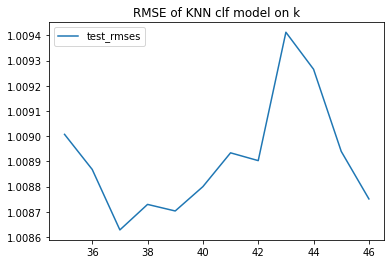

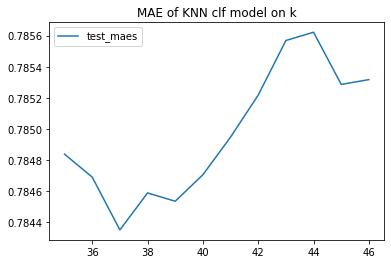

In [46]:
rmses = pd.DataFrame({
    #"train_rmses": train_rmses, 
    "test_rmses": test_rmses, 
}, index = ks
)

maes = pd.DataFrame({
    #"train_maes": train_maes,
    "test_maes": test_maes,
}, index = ks
)

rmses.plot(title= "RMSE of KNN clf model on k")
maes.plot(title= "MAE of KNN clf model on k")

Optimal k value is 45.

In [40]:
optimal_k_value = 37

# Define the KNNBasic algorithm parameters
sim_options = {
    'name': 'cosine',  # You can choose 'pearson', 'cosine', etc.
    'user_based': False,  # Set to False to use item-based collaborative filtering
}

# Create the KNN model
optimal_knn_model = KNNBasic(k=optimal_k_value, sim_options=sim_options, verbose = False)

# Train the model on the training set
knn_model.fit(trainset)

# Get predictions & accuracy for the training set
train_predictions = knn_model.test(trainset.build_testset())
accuracy.rmse(train_predictions)
accuracy.mae(train_predictions)

# Get predictions & accuracy for the test set
predictions = knn_model.test(testset)
test_rmses.append(accuracy.rmse(predictions))
test_maes.append(accuracy.mae(predictions))



In [41]:
# Function to recommend movies for a given user
def get_movie_recommendations(user_id, k=5):
    # Get all movie IDs
    all_movie_ids = df['movie_id'].unique()
    
    # Get movie IDs that the user has already rated
    user_rated_movies = df[df['user_id'] == user_id]['movie_id'].tolist()
    
    # Predict ratings for all movies that the user hasn't rated
    movie_predictions = []
    for movie_id in all_movie_ids:
        if movie_id not in user_rated_movies:
            pred = knn_model.predict(user_id, movie_id)
            movie_predictions.append((movie_id, pred.est))
    
    # Sort by predicted rating and return top k recommendations
    movie_predictions.sort(key=lambda x: x[1], reverse=True)
    top_k_recommendations = movie_predictions[:k]
    
    return top_k_recommendations

# Example: Get movie recommendations for user with ID 1
recommendations = get_movie_recommendations(1)
print(f"Top movie recommendations for user 1: {recommendations}")

Top movie recommendations for user 1: [(1915, 5), (1709, 5), (3290, 5), (1832, 5), (3779, 4.75)]


### Create UIM matrix

In [16]:
test

,user_id,movie_id,rating
280460,5412,2431,5
430017,5440,111,5
642307,368,2976,3
201236,425,2139,4
566230,4942,2532,3
...,...,...,...
261327,5054,316,3
611184,963,3176,3
952928,3320,1981,1
862622,3467,3846,4


In [17]:
# create user-item matrix 
user_to_movie = train.pivot(index = 'user_id', columns='movie_id', values='rating').fillna(0)

user_item_matrix = train.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalization by the average of individual user's rating

Idea : Normalize by extracting mean value per user based on the non-zero ratings of each user to non-zero ratings in the user-item matrix.

Modified matrix will have value ranging from -4 to 4 at theoratical maximum and minimum.
NaN values from the original user_item matrix has no preference on each movie. In our new scale of data, 0 is still the value represents no preference. As both non-viewed movies and the movies received exact mean scores of non-zero ratings of the user will have 0 score.

In [18]:
# Users' average rating on non-zero rating. We deal this rating as no preference. Neither good nor bad as well as non rated movies.
user_rating_avg = user_item_matrix.apply(lambda row: row[row != 0].mean(), axis=1)
user_rating_avg

user_id
1       4.157895
2       3.700000
3       3.923077
4       4.166667
5       3.135714
          ...   
6036    3.326625
6037    3.679487
6038    3.812500
6039    3.897959
6040    3.575875
Length: 6040, dtype: float64

In [19]:
# Function to apply subtraction based on a provided value list
def subtract_non_zero_by_row(row, sub_value):
    # Iterate through each element in the row and subtract the corresponding value only from non-zero elements
    return [val - sub_value if val != 0 else val for val in row]

# Apply the function row-by-row using the subtraction values list
modified_df = user_item_matrix.apply(lambda row: subtract_non_zero_by_row(row, user_rating_avg[row.name]), axis=1, result_type='expand')

print(modified_df.shape)

modified_df.iloc[:10, :10]

(6040, 3670)


,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
5,0.000000,0.000000,0.0,0.0,0.0,-1.135714,0.000000,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
7,0.000000,0.000000,0.0,0.0,0.0,-0.307692,0.000000,0.0,0.0,0.0
8,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
9,1.217949,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


<AxesSubplot:>

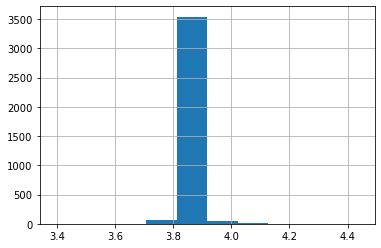

In [20]:
# train KNN model
from sklearn.neighbors import NearestNeighbors

knn_cf = NearestNeighbors(metric='cosine', algorithm='brute')
knn_cf.fit(modified_df)

# Returns average rating per each movie based on the nearest k nearest neighbors found based on the preference on movies. Default is 5.
def clf(user_id, k = 50):
    user_idx = users[users['user_id'] == user_id].index
    user_vect = modified_df.iloc[user_idx, :]

    distances_cf, idx_cf = knn_cf.kneighbors(
        user_vect,
        n_neighbors = k
    )

    predicted_nn = modified_df.iloc[idx_cf[0]].apply(lambda row: row + user_rating_avg[row.name] , axis=1)

    return predicted_nn.apply(np.mean, axis=0)

prediction = clf(1)
prediction.hist()

In [21]:
def get_top_k_movies_rated(user_id, num_recommendations = 5):
    return merged[merged['user_id'] == user_id].sort_values(
        ['rating', 'timestamp'], 
        ascending = False
    ).iloc[:num_recommendations]['title'].values


def get_top_k_movie_recommendations(user_id, k, num_recommendations = 5):
    # indices of top n movies.
    movie_indices = clf(user_id, k).sort_values(ascending = False).iloc[:num_recommendations].index
    return user_item_matrix.iloc[:, movie_indices].columns

def print_knn_result(user_id, num_recommendations = 5):
    print(f'Top {num_recommendations} movies rated by user {user_id}:')
    for movie_name in get_top_k_movies_rated(user_id):
        print(f'\t{movie_name}')        

    print(f'Recommended movies by similar users (collaborative filtering): ')
    for recs in get_top_k_movie_recommendations(user_id):
        print(f'\t{recs}')

print_knn_result(1)

Top 5 movies rated by user 1:
	Pocahontas (1995)
	Bug's Life, A (1998)
	Toy Story (1995)
	Beauty and the Beast (1991)
	Schindler's List (1993)
Recommended movies by similar users (collaborative filtering): 


TypeError: get_top_k_movie_recommendations() missing 1 required positional argument: 'k'

### Model evaluation

In [ ]:
"""
Takes in movies datagrame and merged ratings dataframe and returns a dataframe of movies with ratings only.
Returned dataframe only has 'movie_id', 'title' columns
"""
def movies_idx_df(movies, merged_ratings_df):
    # Exclude none rated movies and reset index.
    rated = movies[movies['movie_id'].isin(merged_ratings_df['movie_id'].unique())]
    return rated.reset_index(drop=True)[['movie_id', 'title']]

def get_movie_idx(movie_id):
    return movie_idx[movie_idx['movie_id'] == movie_id].index

movie_idx = movies_idx_df(movies, merged)

get_movie_idx(3948)

In [ ]:
def caldulate_rmse(df, actual_colname, pred_colname):
    return  np.sqrt(((df[actual_colname] - df[pred_colname]) ** 2).mean())

def make_knn_prediction(df, k = 10):
    df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)
    rmse = np.sqrt(((df['rating'] - df['prediction']) ** 2).mean())
    return df, rmse

prediction, rmse = make_knn_prediction(test, 20)
rmse

In [ ]:
_, train_testset = train_test_split(train, test_size=0.0001, random_state=42)
train_testset

In [ ]:
test

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the k-NN model
knn_model = KNeighborsRegressor()

# Define the parameter grid
param_grid = {
    'n_neighbors': [5, 10, 15, 20],  # Different k values to try
    'weights': ['uniform', 'distance'],  # Test both weighting schemes
    'metric': ['euclidean', 'manhattan']  # Different distance metrics
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Best Parameters: {best_params}")
print(f"Test RMSE: {rmse}")

In [ ]:
train_rmses = []
test_rmses = []
ks = list(range(50, 150, 5))

for k in ks:
    _, train_rmse = make_knn_prediction(train_testset, k)
    train_rmses.append(train_rmse)
    print(train_rmses)
    
    _, test_rmse = make_knn_prediction(test, k)
    test_rmses.append(test_rmse)
    print(test_rmses)


In [ ]:
pd.DataFrame({"train": train_rmses, "test": test_rmses}, index = ks).plot()

In [ ]:
pd.DataFrame({"train": train_rmses, "test": test_rmses}, index = ks).plot()

### Hyperparameter tuning

# Scratchpad

In [86]:
import numpy as np
from pprint import pprint

def get_similar_users(user, n = 5):
    knn_input = np.asarray([user_to_movie.values[user-1]])
        # get user's row from user-item matrix
    distances, indices = knn.kneighbors(knn_input, n_neighbors = n+1)

    print(" ")
    print("Top", n, "users who are very much similar to the User ", user, "are: ")
    for i in range(1,len(distances[0])):
        print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
        
    return indices.flatten()[1:] + 1, distances.flatten()[1:]

def recommend_n_movies(user_id, n_similar_users, n_movie_recs):
    print(f'Movies seen by User {user_id}:')
    pprint(list(merged[merged['user_id'] == user_id]['title']))

    # get n_similar_users and their cosine similarity distances
    similar_users, distance_list = get_similar_users(user_id, n_similar_users)

    # define weights to ratings by each similar user based on distance
        # -> eliminates chance of decision manipulation by users relatively far from input user
    weightage_list = distance_list / np.sum(distance_list)
    
    # get ratings of all movies from similar users
    mov_ratings_sim_users = user_to_movie.loc[similar_users]
    movies_id_list = user_to_movie.columns
    
    # transform to make it compatible for matrix operations
    weightage_list = weightage_list[:, np.newaxis] + np.zeros(len(movies_id_list))
    
    # apply the weights to user ratings
    new_rating_matrix = weightage_list * mov_ratings_sim_users
    
    # get the mean ratings
    mean_rating_list = new_rating_matrix.sum(axis = 0)

    # get n movie indices with the highest mean
        # FIX: remove movies already seen by user
    highest_score_idx = np.argsort(mean_rating_list)[::-1][:n_movie_recs]
    rec_movie_ids = new_rating_matrix.iloc[:, highest_score_idx].columns
    
    print(" ")
    print(f"Top {n_movie_recs} movie recommendations to user {user_id}:")
    rec_movies = []
    for rec_movie_id in rec_movie_ids:
        movie_title = movies[movies['movie_id'] == rec_movie_id]['title'].values[0]
        rec_movies.append(movie_title)
        print(f"\t{movie_title}")

    return rec_movies

In [ ]:
# Fix wrong input by user
from fuzzywuzzy import fuzz

def get_title_from_id(id):
    # convert idx to title
    return movies[movies['movie_id'] == id]['title'].values[0]

def get_id_from_title(title):
    # convert title to idx
    return movies[movies['title'] == title]['movie_id'].values[0]
    
def matching_score(a, b):
    # calculate the Levenshtein distance to find closest title
        # if exactly same score == 100
    return fuzz.ratio(a, b) 

def find_closest_title(title):
    leven_scores = list(enumerate(movies['title'].apply(matching_score, b = title)))
    sorted_lev_scores = sorted(leven_scores, key = lambda x: x[1], reverse = True)

    closest_idx = sorted_lev_scores[0][0]
    closest_movie = movies.loc[closest_idx]
    distance_score = sorted_lev_scores[0][1]

    closest_movie_id = closest_movie['movie_id']
    closest_movie_title = closest_movie['title']
    
    return (closest_movie_id, closest_movie_title, distance_score)

def rec_movies_by_name(movie_name, n_movie_recs = 10):
    closest_id, closest_movie, distance_score = find_closest_title(movie_name)
    if distance_score != 100:
        movie_name = closest_movie
        print(f"Did you mean {movie_name}?")
    
    movie_id = get_id_from_title(movie_name)

    knn_input = np.asarray([movie_to_user.values[movie_id]])

    movie_ids_list = movie_to_user.index
    n = min(len(movie_ids_list), n_movie_recs)
        # if n_movie_recs goes over number of movies, revert to all movies
    distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors = n + 1) 

    print(f"Top {n} movies which are very similar to movie {movie_name} are: \n")
    for i in range(1, len(distances[0])):
        movie_id = movie_ids_list[indices[0][i]]
        movie_title = get_title_from_id(movie_id)
        print(movie_title)

movie_title = 'willy woka choco'
rec_movies_by_name(movie_title, 20)

In [ ]:
# !! ARCHIVED !! For initial content-based rec model that takes movie name instead of user id as input
# Fuzzy string matching to fix wrong movie input by user
from pprint import pprint
from fuzzywuzzy import fuzz

def get_movie_from_idx(idx):
    # get movie details from idx
    title = content_rec.loc[idx, 'title']
    year = content_rec.loc[idx, 'year']

    return title, year
    
def get_idx_from_title(title):
    # convert title to idx
    return content_rec[content_rec['title'] == title].index.values[0]

# Fix wrong input by user
def matching_score(a, b):
    # calculate the Levenshtein distance to find closest title
        # if exactly same score == 100
    return fuzz.ratio(a, b) 
    
def find_closest_title(title):
    leven_scores = list(enumerate(content_rec['title'].apply(matching_score, b = title)))
    sorted_lev_scores = sorted(leven_scores, key = lambda x: x[1], reverse = True)

    closest_idx = sorted_lev_scores[0][0]
    closest_movie = content_rec.loc[closest_idx]
    distance_score = sorted_lev_scores[0][1]

    closest_movie_id = closest_movie['movie_id']
    closest_movie_title = closest_movie['title']
        
    return (closest_movie_id, closest_movie_title, distance_score)

In [ ]:
"""
from scipy.sparse import csr_matrix

# since we're using cosine similarity, we can fill with 0 
# cosine similarity does not take magnitude to account
refined = merged.groupby(['user_id', 'movie_id'], as_index = False).agg({'rating': 'mean'})

# create user-item matrix 
user_to_movie = refined.pivot(index = 'user_id', columns='movie_id', values='rating').fillna(0)
# convert to csr matrix for efficiency (sparse matrix optimization)
user_to_movie_sparse = csr_matrix(user_to_movie.values)

user_item_matrix = merged.pivot(index = 'user_id', columns = 'title', values = 'rating').fillna(0)
user_item_csr = csr_matrix(user_item_matrix.values)
user_item_matrix
"""